# Soil Variables Generation

In this notebook, we generate soil-related variables to complement our groundwater data using the SoilGrids service.

#### Load libraries

In [1]:
from soilgrids import SoilGrids
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### Load auxiliary data

In [11]:
df_coord = pd.read_csv('gw_coordinates_df.csv')

### Retrieving variables from soilgrids

#### Definition of the variables of interest

In [12]:
service_id_list = ['bdod', 'cec', 'cfvo', 'clay', 'nitrogen', 'phh2o', 'sand', 'silt', 'soc', 'ocs', 'ocd']

In [13]:
vars_list = []
for service_id in service_id_list:
    if service_id == 'ocs':
        vars_list += [f'{service_id}_mean_0-30cm', f'{service_id}_max_0-30cm', f'{service_id}_min_0-30cm']
    else:
        vars_list += [f'{service_id}_mean_0-5cm', f'{service_id}_max_0-5cm', f'{service_id}_min_0-5cm']
        vars_list += [f'{service_id}_mean_100-200cm', f'{service_id}_max_100-200cm', f'{service_id}_min_100-200cm']

#### Fetching the data

This code iterates over the list of geographic coordinates, defines a bounding box (approximately 2 km²) around each location, and retrieves soil data from the SoilGrids service. For each location and depth, it calculates the mean, max, and min values of the soil variables and stores the results in a DataFrame. If an error occurs while fetching the data, it logs the error and fills the corresponding entries with None.

In [6]:
extra_vars = pd.DataFrame()

# Define an approximately 2 km² bounding box around the coordinates
distance_deg = 0.045  # Roughly 1 km in degrees

# Iterate over each row in the df_coord DataFrame
for index, row in df_coord.iterrows():
    latitude = float(row['latitude'])
    longitude = float(row['longitude'])

    # Define the bounding box (in degrees of latitude and longitude)
    west = longitude - distance_deg
    east = longitude + distance_deg
    south = latitude - distance_deg
    north = latitude + distance_deg

    # Log the bounding box and the current location being processed
    print(f"Processing id_loc: {row['id_loc']}, BBOX: West={west}, East={east}, South={south}, North={north}")

    # Initialize the SoilGrids service to retrieve soil data
    soil_grids = SoilGrids()
    extra_vars_row = []

    for service_id in service_id_list:
        # If the service is 'ocs', retrieve data only for the 0-30 cm depth
        if service_id == 'ocs':
            try:
                # Fetch coverage data for 0-30 cm depth
                data = soil_grids.get_coverage_data(
                    service_id=service_id,
                    coverage_id=f'{service_id}_0-30cm_mean',  # Only 0-30cm for 'ocs'
                    west=west,
                    south=south,
                    east=east,
                    north=north,
                    crs="urn:ogc:def:crs:EPSG::4326",  # CRS EPSG:4326 (lat/lon)
                    output=f"soil_data_{row['id_loc']}.tif",  # Output file for each location
                    height=256,
                    width=256
                )
                # Handle missing data (replace invalid values)
                data = data.where(data != -32768, np.nan)

                # Calculate and store mean, max, and min values
                extra_vars_row.append(np.nanmean(data.values))
                extra_vars_row.append(np.nanmax(data.values))
                extra_vars_row.append(np.nanmin(data.values))

            except Exception as e:
                # Log the error and append None for the failed data retrieval
                print(f"Error processing id_loc: {row['id_loc']} for ocs. Exception: {str(e)}")
                extra_vars_row.extend([None, None, None])

        # For other services (not 'ocs')
        else:
            try:
                # Fetch coverage data for 0-5 cm depth
                data = soil_grids.get_coverage_data(
                    service_id=service_id,
                    coverage_id=f'{service_id}_0-5cm_mean',
                    west=west,
                    south=south,
                    east=east,
                    north=north,
                    crs="urn:ogc:def:crs:EPSG::4326",
                    output=f"soil_data_{row['id_loc']}.tif",
                    height=256,
                    width=256
                )
                # Handle missing data (replace invalid values)
                data = data.where(data != -32768, np.nan)

                # Calculate and store mean, max, and min values
                extra_vars_row.append(np.nanmean(data.values))
                extra_vars_row.append(np.nanmax(data.values))
                extra_vars_row.append(np.nanmin(data.values))

            except Exception as e:
                # Log the error and append None for the failed data retrieval
                print(f"Error processing id_loc: {row['id_loc']}. Exception: {str(e)}")
                extra_vars_row.extend([None, None, None])

            try:
                # Fetch coverage data for 100-200 cm depth
                data = soil_grids.get_coverage_data(
                    service_id=service_id,
                    coverage_id=f'{service_id}_100-200cm_mean',
                    west=west,
                    south=south,
                    east=east,
                    north=north,
                    crs="urn:ogc:def:crs:EPSG::4326",
                    output=f"soil_data_{row['id_loc']}.tif",
                    height=32,
                    width=32
                )
                # Handle missing data (replace invalid values)
                data = data.where(data != -32768, np.nan)

                # Calculate and store mean, max, and min values
                extra_vars_row.append(np.nanmean(data.values))
                extra_vars_row.append(np.nanmax(data.values))
                extra_vars_row.append(np.nanmin(data.values))

            except Exception as e:
                # Log the error and append None for the failed data retrieval
                print(f"Error processing id_loc: {row['id_loc']}. Exception: {str(e)}")
                extra_vars_row.extend([None, None, None])

    # Append the row's results to the extra_vars DataFrame
    extra_vars = pd.concat([extra_vars, pd.DataFrame(extra_vars_row).T], axis=0)

# Assign meaningful column names based on the list of variables
extra_vars.columns = vars_list

Processing id_loc: 324095.0, BBOX: West=14.2625, East=14.3525, South=48.265277777777776, North=48.35527777777778
Processing id_loc: 323295.0, BBOX: West=14.25777777777778, East=14.34777777777778, South=48.28527777777778, North=48.37527777777778
Processing id_loc: 323154.0, BBOX: West=14.304444444444446, East=14.394444444444446, South=48.23805555555556, North=48.328055555555565
Processing id_loc: 304535.0, BBOX: West=16.827222222222222, East=16.917222222222225, South=48.261111111111106, North=48.35111111111111
Processing id_loc: 326934.0, BBOX: West=16.244166666666665, East=16.33416666666667, South=47.87083333333333, North=47.96083333333333
Processing id_loc: 307397.0, BBOX: West=14.015555555555556, East=14.105555555555556, South=48.23138888888889, North=48.32138888888889
Processing id_loc: 319053.0, BBOX: West=15.935555555555556, East=16.025555555555556, South=46.66444444444445, North=46.75444444444445
Processing id_loc: 303727.0, BBOX: West=16.008333333333333, East=16.098333333333336,

#### Checking if many NaN's were 

<Axes: >

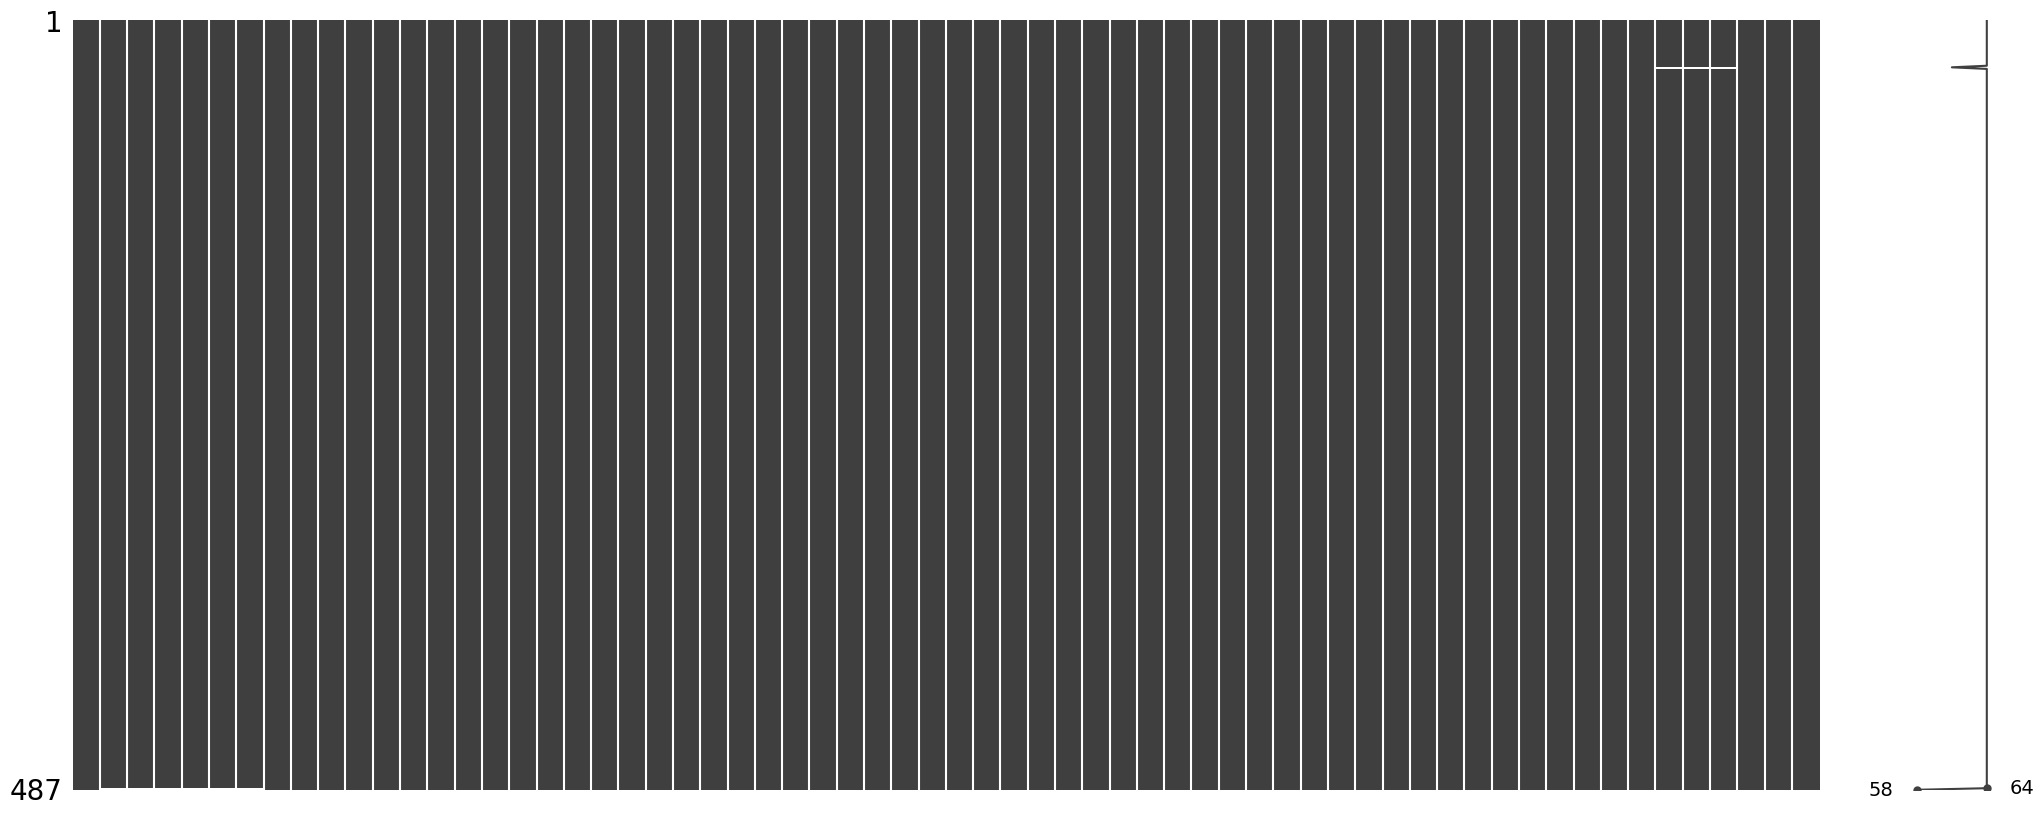

In [7]:
import missingno as msno
msno.matrix(extra_vars)

Since very few nans were generated we'll just fill them with the mean.

In [8]:
extra_vars = extra_vars.fillna(extra_vars.mean())

### Soil type data

We now repeat the previous process but retrieven the types of soil in each location. The way this variable works makes it very difficult to retrieve this information in the same execution as the previous variables.

In [9]:
# List of soil types
soil_types = [
    "Acrisols", "Albeluvisols", "Alisols", "Andosols", "Arenosols", "Calcisols", "Cambisols", 
    "Chernozems", "Cryosols", "Durisols", "Ferralsols", "Fluvisols", "Gleysols", "Gypsisols", 
    "Histosols", "Kastanozems", "Leptosols", "Lixisols", "Luvisols", 
    "Nitisols", "Phaeozems", "Planosols", "Plinthosols", "Podzols", "Regosols", "Solonchaks", 
    "Solonetz", "Stagnosols", "Umbrisols", "Vertisols"
]

# Create a dictionary mapping each index to its corresponding soil type
soil_dict = {i: soil_types[i] for i in range(len(soil_types))}

In [14]:
wrb_col = []

# Define a bounding box of approximately 2 km² around the coordinates
distance_deg = 0.045  # Roughly 1 km in degrees

# Iterate over each row in the df_coord DataFrame
for index, row in df_coord.iterrows():
    latitude = float(row['latitude'])
    longitude = float(row['longitude'])

    # Define bounding box limits in degrees of latitude and longitude
    west = longitude - distance_deg
    east = longitude + distance_deg
    south = latitude - distance_deg
    north = latitude + distance_deg

    # Log the bounding box and current location
    print(f"Processing id_loc: {row['id_loc']}, BBOX: West={west}, East={east}, South={south}, North={north}")

    # Retrieve SoilGrids data for the given bounding box
    soil_grids = SoilGrids()

    try:
        data = soil_grids.get_coverage_data(
            service_id='wrb',
            coverage_id='MostProbable',
            west=west,
            south=south,
            east=east,
            north=north,
            crs="urn:ogc:def:crs:EPSG::4326",  # EPSG:4326 projection (lat/lon)
            output=f"soil_data_{row['id_loc']}.tif",  # Output file for each location
            height=256,
            width=256
        )

        # Filter out invalid values (255) from the data
        data = data.where(data != 255, np.nan)

        # Flatten the array and remove NaNs
        flattened_data = data.values.flatten()
        valid_data = flattened_data[~np.isnan(flattened_data)]

        # Calculate frequency of each soil type using bincount
        if valid_data.size > 0:
            counts = np.bincount(valid_data.astype(int), minlength=30)
            percentages = counts[1:] / valid_data.size * 100  # Ignore value 0 and compute percentages
        else:
            percentages = [np.nan] * 29  # Return NaNs if no valid data

        # Append the list of percentages to wrb_col
        wrb_col.append(percentages)

    except Exception as e:
        # Handle errors and append NaNs
        print(f"Error processing id_loc: {row['id_loc']} for ocs. Exception: {str(e)}")
        wrb_col.append([np.nan] * 30)

# Convert wrb_col to a DataFrame
wrb_df = pd.DataFrame(wrb_col, columns=[soil_dict[i] for i in range(1, 30)])

Processing id_loc: 324095.0, BBOX: West=14.2625, East=14.3525, South=48.265277777777776, North=48.35527777777778
Processing id_loc: 323295.0, BBOX: West=14.25777777777778, East=14.34777777777778, South=48.28527777777778, North=48.37527777777778
Processing id_loc: 323154.0, BBOX: West=14.304444444444446, East=14.394444444444446, South=48.23805555555556, North=48.328055555555565
Processing id_loc: 304535.0, BBOX: West=16.827222222222222, East=16.917222222222225, South=48.261111111111106, North=48.35111111111111
Processing id_loc: 326934.0, BBOX: West=16.244166666666665, East=16.33416666666667, South=47.87083333333333, North=47.96083333333333
Processing id_loc: 307397.0, BBOX: West=14.015555555555556, East=14.105555555555556, South=48.23138888888889, North=48.32138888888889
Processing id_loc: 319053.0, BBOX: West=15.935555555555556, East=16.025555555555556, South=46.66444444444445, North=46.75444444444445
Processing id_loc: 303727.0, BBOX: West=16.008333333333333, East=16.098333333333336,

ValueError: 29 columns passed, passed data had 30 columns

#### Transforming soil type data to dataframe and processing it

In [32]:
# Convert wrb_col (list of percentages) to a DataFrame with soil types as columns
wrb_df = pd.DataFrame(wrb_col, columns=[soil_dict[i] for i in range(1, 30)])

# Keep only columns where at least one value is greater than 0.5%
wrb_df = wrb_df.loc[:, (wrb_df > 0.5).any()]

# Fill missing values (NaNs) with the column mean
wrb_df = wrb_df.fillna(wrb_df.mean())

#### Merge with previous soil data

In [43]:
df_result = pd.concat([df_coord, extra_vars.reset_index(drop = True), wrb_df], axis = 1)

### Saving final soil variables dataframe

In [ ]:
df_result.to_csv("soil_data_stage2.csv", index = False)